# Library

In [1]:
# Installation
%pip install --quiet mesa

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import
import mesa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from tabulate import tabulate

import math
import random

# Class Definition

## Agent

In [3]:
class ChartistAgent(mesa.Agent):
    def __init__(self, id, model, fiat_owned, bitcoin_owned, chartist_day_reference):
        super().__init__(id, model)

        # Attribute Initialization         
        self.fiat = fiat_owned
        self.bitcoin = bitcoin_owned
        self.total_value_obtained = self.fiat + (self.bitcoin * self.model.price) - self.model.initial_fiat_owned
        self.is_close = True
        self.n = chartist_day_reference
        self.ratio_bitcoin_fiat = round(self.bitcoin / self.fiat, 2) if self.fiat > 0 else 0
        
        # Default Rule : EMA for both opening and closing
        self.is_open_sma_high = False
        self.is_close_sma_high = False
        
        if (np.random.uniform() <= 0.25):
            # Rule : SMA for both opening and closing             
            self.is_open_sma_high = True
            self.is_close_sma_high = True
        elif (np.random.uniform() > 0.25 and np.random.uniform() < 0.5):
            # Rule : SMA for opening and EMA for closing
            self.is_open_sma_high = True
        elif (np.random.uniform() > 0.25 and np.random.uniform() < 0.75):
            # Rule : EMA for opening and SMA for closing
            self.is_close_sma_high = True
    
    def step(self):
        if self.is_close:
            # Potential Buy
            sma_value = self.calculate_sma_n_days()
            ema_value = self.calculate_ema_n_days()
            
            # Count Probability to Buy Based on Rule
            probability_to_buy = 0
            if self.model.price < sma_value:
                probability_to_buy += (0.8 if self.is_open_sma_high else 0.2)
            
            if self.model.price > ema_value:
                probability_to_buy += (0.8 if not self.is_open_sma_high else 0.2)
            
            # Actual Buy
            if (np.random.uniform() <= probability_to_buy):
                self.is_close = False
                
                bitcoin_obtained = math.floor((self.fiat / self.model.price) * 10000) / 10000
                self.bitcoin += bitcoin_obtained
                self.fiat -= self.bitcoin * self.model.price
                self.model.demand += bitcoin_obtained

                if (self.is_close_sma_high and self.is_close_sma_high):
                    self.model.number_of_open_position_R1R1_agent += 1
                elif (self.is_close_sma_high and not self.is_close_sma_high):
                    self.model.number_of_open_position_R1R2_agent += 1
                elif (not self.is_close_sma_high and self.is_close_sma_high):
                    self.model.number_of_open_position_R2R1_agent += 1
                elif (not self.is_close_sma_high and not self.is_close_sma_high):
                    self.model.number_of_open_position_R2R2_agent += 1
    
        else:
            # Potential Sell
            sma_value = self.calculate_sma_n_days()
            ema_value = self.calculate_ema_n_days()

            # Count Probability to Sell Based on Rule
            probability_to_sell = 0
            if self.model.price > sma_value:
                probability_to_sell += (0.8 if self.is_close_sma_high else 0.2)
            
            if self.model.price < ema_value:
                probability_to_sell += (0.8 if not self.is_close_sma_high else 0.2)
            
            # Actual Sell
            if (np.random.uniform() <= probability_to_sell):
                self.is_close = True
                
                bitcoin_released = self.bitcoin
                self.fiat += self.bitcoin * self.model.price
                self.bitcoin -= bitcoin_released
                self.model.supply += bitcoin_released
                
                if (self.is_close_sma_high and self.is_close_sma_high):
                    self.model.number_of_open_position_R1R1_agent -= 1
                elif (self.is_close_sma_high and not self.is_close_sma_high):
                    self.model.number_of_open_position_R1R2_agent -= 1
                elif (not self.is_close_sma_high and self.is_close_sma_high):
                    self.model.number_of_open_position_R2R1_agent -= 1
                elif (not self.is_close_sma_high and not self.is_close_sma_high):
                    self.model.number_of_open_position_R2R2_agent -= 1
        
        self.total_value_obtained = self.fiat + (self.bitcoin * self.model.price) - self.model.initial_fiat_owned
        self.ratio_bitcoin_fiat = round(self.bitcoin / self.fiat, 2) if self.fiat > 0 else 0
                    
    # Agent Helper Function
    # SMA Rule
    def calculate_sma_n_days(self):
        start_index = max(0, len(self.model.price_history) - self.n)
        window = self.model.price_history[start_index:len(self.model.price_history)]

        return sum(window) / len(window)

    # EMA Rule
    def calculate_ema_n_days(self):
        smooth_factor = 2 / (self.n + 1)
        ema = [self.model.price_history[0]]

        for i in range(1, len(self.model.price_history)):
            value = smooth_factor * self.model.price_history[i] + (1 - smooth_factor) * ema[i-1]
            ema.append(value)

        return ema[len(ema)-1]

In [4]:
class RandomAgent(mesa.Agent):
    def __init__(self, id, model, fiat_owned, bitcoin_owned):
        super().__init__(id, model)

        # Attribute Initialization         
        self.fiat = fiat_owned
        self.bitcoin = bitcoin_owned
        self.total_value_obtained = self.fiat + (self.bitcoin * self.model.price) - self.model.initial_fiat_owned
        self.is_close = True
        self.ratio_bitcoin_fiat = round(self.bitcoin / self.fiat, 2) if self.fiat > 0 else 0
    
    def step(self):
        if self.is_close:
            # Actual Buy
            if (random.choice([True, False])):
                self.is_close = False

                bitcoin_obtained = math.floor((self.fiat / self.model.price) * 10000) / 10000
                self.bitcoin += bitcoin_obtained
                self.fiat -= self.bitcoin * self.model.price
                self.model.demand += bitcoin_obtained
                self.model.number_of_open_position_random_agent += 1
    
        else:
            # Actual Sell
            if (random.choice([True, False])):
                self.is_close = True
                
                bitcoin_released = self.bitcoin
                self.fiat += self.bitcoin * self.model.price
                self.bitcoin -= bitcoin_released
                self.model.supply += bitcoin_released
                self.model.number_of_open_position_random_agent -= 1

        self.total_value_obtained = self.fiat + (self.bitcoin * self.model.price) - self.model.initial_fiat_owned
        self.ratio_bitcoin_fiat = round(self.bitcoin / self.fiat, 2) if self.fiat > 0 else 0

In [5]:
import random

class BitcoinMarketModel(mesa.Model):
    def __init__(self, price_start, number_of_agents, total_fiat, total_bitcoin, chartist_ratio, chartist_day_reference):
        self.schedule = mesa.time.RandomActivation(self)
        
        self.price = price_start
        self.price_history = [price_start]
        self.number_of_agents = number_of_agents
        
        self.total_fiat = total_fiat
        self.total_bitcoin = total_bitcoin
        self.supply = 0
        self.demand = 0
        
        self.number_of_open_position_R1R1_agent = 0
        self.number_of_open_position_R1R2_agent = 0
        self.number_of_open_position_R2R1_agent = 0
        self.number_of_open_position_R2R2_agent = 0
        self.number_of_open_position_random_agent = 0

        # For Intermediary Process
        self.steps = 0
        self.agents = []
        
        self.chartist_ratio = chartist_ratio
        self.initial_fiat_owned = self.total_fiat / self.number_of_agents
        self.chartist_day_reference = chartist_day_reference
        
        # For Batch Run         
        self.running = True
        
        number_of_chartist = math.floor(self.chartist_ratio * self.number_of_agents)
        number_of_random = self.number_of_agents - number_of_chartist
        fiat_owned = self.initial_fiat_owned
        bitcoin_owned = 0

        for i in range(number_of_chartist):
            a = ChartistAgent(str(f"chartist-{i}"), 
                              self, 
                              fiat_owned,
                              bitcoin_owned, 
                              chartist_day_reference)

            self.schedule.add(a)
            self.agents.append(a)
        
        for i in range(number_of_random):
            a = RandomAgent(str(f"random-{i}"), 
                          self, 
                          fiat_owned,
                          bitcoin_owned)

            self.schedule.add(a)
            self.agents.append(a)
        
        self.datacollector = mesa.DataCollector(
            model_reporters={"Price": "price", 
                             "Number_of_agents": "number_of_agents", 
                             "Open_R1R1": "number_of_open_position_R1R1_agent", 
                             "Open_R1R2": "number_of_open_position_R1R2_agent", 
                             "Open_R2R1": "number_of_open_position_R2R1_agent", 
                             "Open_R2R2": "number_of_open_position_R2R2_agent", 
                             "Open_Random": "number_of_open_position_random_agent"}, 
            agent_reporters={"Fiat": "fiat", 
                             "Bitcoin": "bitcoin", 
                             "TOV": "total_value_obtained", 
                             "RBF": "ratio_bitcoin_fiat",
                             "OpenSMA": "is_open_sma_high", 
                             "CloseSMA": "is_close_sma_high"}
        )
    
    def step(self):
        # Before Stepping
        self.price += self.calculate_today_price_change()
        self.supply = 0
        self.demand = 0
        
        self.datacollector.collect(self)
        
        # Stepping
        self.schedule.step()
        self.steps += 1
        print(f'{self.chartist_day_reference} - {self.steps}/1400')
        
        # After Stepping
        self.price_history.append(self.price)
        
        # Monthly Adjustment
        if (self.steps % 30 == 0):
#             # Add New Agents
#             old_number_of_agents = self.number_of_agents
#             self.number_of_agents += math.floor(0.02 * self.number_of_agents)
            
#             number_of_chartist = math.floor(self.chartist_ratio * self.number_of_agents)
#             number_of_random = self.number_of_agents - number_of_chartist
#             fiat_owned = self.initial_fiat_owned
#             bitcoin_owned = 0
#             chartist_day_reference = self.chartist_day_reference
            
#             for i in range(number_of_chartist):
#                 a = ChartistAgent(str(f"add-chartist-{i}-at-{self.steps}"), 
#                                   self, 
#                                   fiat_owned,
#                                   bitcoin_owned, 
#                                   chartist_day_reference)

#                 self.schedule.add(a)
#                 self.agents.append(a)

#             for i in range(number_of_random):
#                 a = RandomAgent(str(f"add-random-{i}-at-{self.steps}"), 
#                               self, 
#                               fiat_owned,
#                               bitcoin_owned)

#                 self.schedule.add(a)
#                 self.agents.append(a)
                    
            # Add New Bitcoins to Traders
            valuable_agents = []
            total_bitcoin_in_agents = 0
            for i in range(len(self.agents)):
                agent = self.agents[i]
                
                if (agent.bitcoin != 0):
                    valuable_agents.append(agent)
                    total_bitcoin_in_agents += agent.bitcoin
            
            total_new_bitcoin = round(0.076 * self.total_bitcoin, 4)
            self.total_bitcoin += total_new_bitcoin
            
            for i in range(len(valuable_agents)):
                agent = valuable_agents[i]
                
                ratio = agent.bitcoin / total_bitcoin_in_agents
                
                agent.bitcoin += round(ratio * total_new_bitcoin, 4)
        
    # Model Helper Function
    # Calculate Price
    def calculate_today_price_change(self):
        supply_demand_difference = self.demand - self.supply
        sign = math.copysign(1, supply_demand_difference)
        
        return math.floor((math.sqrt(2) / 2) *  sign * math.sqrt(abs(supply_demand_difference)))

# Task 2 SIMULATION

In [6]:
# Agents Parameters
params = {"price_start": 5614, 
          "number_of_agents": 112, 
          "total_fiat": 140112, 
          "total_bitcoin": 108.8499, 
          "chartist_ratio": 0.6, 
          "chartist_day_reference": range(1, 10, 2)}

max_steps = 1400

results = mesa.batch_run(
    BitcoinMarketModel,
    parameters=params,
    iterations=1,
    number_processes=1,
    max_steps=max_steps,
    data_collection_period=1,
    display_progress=True,
)

results_df = pd.DataFrame(results)
# print(results_df)

  0%|          | 0/5 [00:00<?, ?it/s]

1 - 1/1400
1 - 2/1400
1 - 3/1400
1 - 4/1400
1 - 5/1400
1 - 6/1400
1 - 7/1400
1 - 8/1400
1 - 9/1400
1 - 10/1400
1 - 11/1400
1 - 12/1400
1 - 13/1400
1 - 14/1400
1 - 15/1400
1 - 16/1400
1 - 17/1400
1 - 18/1400
1 - 19/1400
1 - 20/1400
1 - 21/1400
1 - 22/1400
1 - 23/1400
1 - 24/1400
1 - 25/1400
1 - 26/1400
1 - 27/1400
1 - 28/1400
1 - 29/1400
1 - 30/1400
1 - 31/1400
1 - 32/1400
1 - 33/1400
1 - 34/1400
1 - 35/1400
1 - 36/1400
1 - 37/1400
1 - 38/1400
1 - 39/1400
1 - 40/1400
1 - 41/1400
1 - 42/1400
1 - 43/1400
1 - 44/1400
1 - 45/1400
1 - 46/1400
1 - 47/1400
1 - 48/1400
1 - 49/1400
1 - 50/1400
1 - 51/1400
1 - 52/1400
1 - 53/1400
1 - 54/1400
1 - 55/1400
1 - 56/1400
1 - 57/1400
1 - 58/1400
1 - 59/1400
1 - 60/1400
1 - 61/1400
1 - 62/1400
1 - 63/1400
1 - 64/1400
1 - 65/1400
1 - 66/1400
1 - 67/1400
1 - 68/1400
1 - 69/1400
1 - 70/1400
1 - 71/1400
1 - 72/1400
1 - 73/1400
1 - 74/1400
1 - 75/1400
1 - 76/1400
1 - 77/1400
1 - 78/1400
1 - 79/1400
1 - 80/1400
1 - 81/1400
1 - 82/1400
1 - 83/1400
1 - 84/1400
1

1 - 653/1400
1 - 654/1400
1 - 655/1400
1 - 656/1400
1 - 657/1400
1 - 658/1400
1 - 659/1400
1 - 660/1400
1 - 661/1400
1 - 662/1400
1 - 663/1400
1 - 664/1400
1 - 665/1400
1 - 666/1400
1 - 667/1400
1 - 668/1400
1 - 669/1400
1 - 670/1400
1 - 671/1400
1 - 672/1400
1 - 673/1400
1 - 674/1400
1 - 675/1400
1 - 676/1400
1 - 677/1400
1 - 678/1400
1 - 679/1400
1 - 680/1400
1 - 681/1400
1 - 682/1400
1 - 683/1400
1 - 684/1400
1 - 685/1400
1 - 686/1400
1 - 687/1400
1 - 688/1400
1 - 689/1400
1 - 690/1400
1 - 691/1400
1 - 692/1400
1 - 693/1400
1 - 694/1400
1 - 695/1400
1 - 696/1400
1 - 697/1400
1 - 698/1400
1 - 699/1400
1 - 700/1400
1 - 701/1400
1 - 702/1400
1 - 703/1400
1 - 704/1400
1 - 705/1400
1 - 706/1400
1 - 707/1400
1 - 708/1400
1 - 709/1400
1 - 710/1400
1 - 711/1400
1 - 712/1400
1 - 713/1400
1 - 714/1400
1 - 715/1400
1 - 716/1400
1 - 717/1400
1 - 718/1400
1 - 719/1400
1 - 720/1400
1 - 721/1400
1 - 722/1400
1 - 723/1400
1 - 724/1400
1 - 725/1400
1 - 726/1400
1 - 727/1400
1 - 728/1400
1 - 729/1400

1 - 1298/1400
1 - 1299/1400
1 - 1300/1400
1 - 1301/1400
1 - 1302/1400
1 - 1303/1400
1 - 1304/1400
1 - 1305/1400
1 - 1306/1400
1 - 1307/1400
1 - 1308/1400
1 - 1309/1400
1 - 1310/1400
1 - 1311/1400
1 - 1312/1400
1 - 1313/1400
1 - 1314/1400
1 - 1315/1400
1 - 1316/1400
1 - 1317/1400
1 - 1318/1400
1 - 1319/1400
1 - 1320/1400
1 - 1321/1400
1 - 1322/1400
1 - 1323/1400
1 - 1324/1400
1 - 1325/1400
1 - 1326/1400
1 - 1327/1400
1 - 1328/1400
1 - 1329/1400
1 - 1330/1400
1 - 1331/1400
1 - 1332/1400
1 - 1333/1400
1 - 1334/1400
1 - 1335/1400
1 - 1336/1400
1 - 1337/1400
1 - 1338/1400
1 - 1339/1400
1 - 1340/1400
1 - 1341/1400
1 - 1342/1400
1 - 1343/1400
1 - 1344/1400
1 - 1345/1400
1 - 1346/1400
1 - 1347/1400
1 - 1348/1400
1 - 1349/1400
1 - 1350/1400
1 - 1351/1400
1 - 1352/1400
1 - 1353/1400
1 - 1354/1400
1 - 1355/1400
1 - 1356/1400
1 - 1357/1400
1 - 1358/1400
1 - 1359/1400
1 - 1360/1400
1 - 1361/1400
1 - 1362/1400
1 - 1363/1400
1 - 1364/1400
1 - 1365/1400
1 - 1366/1400
1 - 1367/1400
1 - 1368/1400
1 - 13

3 - 576/1400
3 - 577/1400
3 - 578/1400
3 - 579/1400
3 - 580/1400
3 - 581/1400
3 - 582/1400
3 - 583/1400
3 - 584/1400
3 - 585/1400
3 - 586/1400
3 - 587/1400
3 - 588/1400
3 - 589/1400
3 - 590/1400
3 - 591/1400
3 - 592/1400
3 - 593/1400
3 - 594/1400
3 - 595/1400
3 - 596/1400
3 - 597/1400
3 - 598/1400
3 - 599/1400
3 - 600/1400
3 - 601/1400
3 - 602/1400
3 - 603/1400
3 - 604/1400
3 - 605/1400
3 - 606/1400
3 - 607/1400
3 - 608/1400
3 - 609/1400
3 - 610/1400
3 - 611/1400
3 - 612/1400
3 - 613/1400
3 - 614/1400
3 - 615/1400
3 - 616/1400
3 - 617/1400
3 - 618/1400
3 - 619/1400
3 - 620/1400
3 - 621/1400
3 - 622/1400
3 - 623/1400
3 - 624/1400
3 - 625/1400
3 - 626/1400
3 - 627/1400
3 - 628/1400
3 - 629/1400
3 - 630/1400
3 - 631/1400
3 - 632/1400
3 - 633/1400
3 - 634/1400
3 - 635/1400
3 - 636/1400
3 - 637/1400
3 - 638/1400
3 - 639/1400
3 - 640/1400
3 - 641/1400
3 - 642/1400
3 - 643/1400
3 - 644/1400
3 - 645/1400
3 - 646/1400
3 - 647/1400
3 - 648/1400
3 - 649/1400
3 - 650/1400
3 - 651/1400
3 - 652/1400

3 - 1218/1400
3 - 1219/1400
3 - 1220/1400
3 - 1221/1400
3 - 1222/1400
3 - 1223/1400
3 - 1224/1400
3 - 1225/1400
3 - 1226/1400
3 - 1227/1400
3 - 1228/1400
3 - 1229/1400
3 - 1230/1400
3 - 1231/1400
3 - 1232/1400
3 - 1233/1400
3 - 1234/1400
3 - 1235/1400
3 - 1236/1400
3 - 1237/1400
3 - 1238/1400
3 - 1239/1400
3 - 1240/1400
3 - 1241/1400
3 - 1242/1400
3 - 1243/1400
3 - 1244/1400
3 - 1245/1400
3 - 1246/1400
3 - 1247/1400
3 - 1248/1400
3 - 1249/1400
3 - 1250/1400
3 - 1251/1400
3 - 1252/1400
3 - 1253/1400
3 - 1254/1400
3 - 1255/1400
3 - 1256/1400
3 - 1257/1400
3 - 1258/1400
3 - 1259/1400
3 - 1260/1400
3 - 1261/1400
3 - 1262/1400
3 - 1263/1400
3 - 1264/1400
3 - 1265/1400
3 - 1266/1400
3 - 1267/1400
3 - 1268/1400
3 - 1269/1400
3 - 1270/1400
3 - 1271/1400
3 - 1272/1400
3 - 1273/1400
3 - 1274/1400
3 - 1275/1400
3 - 1276/1400
3 - 1277/1400
3 - 1278/1400
3 - 1279/1400
3 - 1280/1400
3 - 1281/1400
3 - 1282/1400
3 - 1283/1400
3 - 1284/1400
3 - 1285/1400
3 - 1286/1400
3 - 1287/1400
3 - 1288/1400
3 - 12

5 - 497/1400
5 - 498/1400
5 - 499/1400
5 - 500/1400
5 - 501/1400
5 - 502/1400
5 - 503/1400
5 - 504/1400
5 - 505/1400
5 - 506/1400
5 - 507/1400
5 - 508/1400
5 - 509/1400
5 - 510/1400
5 - 511/1400
5 - 512/1400
5 - 513/1400
5 - 514/1400
5 - 515/1400
5 - 516/1400
5 - 517/1400
5 - 518/1400
5 - 519/1400
5 - 520/1400
5 - 521/1400
5 - 522/1400
5 - 523/1400
5 - 524/1400
5 - 525/1400
5 - 526/1400
5 - 527/1400
5 - 528/1400
5 - 529/1400
5 - 530/1400
5 - 531/1400
5 - 532/1400
5 - 533/1400
5 - 534/1400
5 - 535/1400
5 - 536/1400
5 - 537/1400
5 - 538/1400
5 - 539/1400
5 - 540/1400
5 - 541/1400
5 - 542/1400
5 - 543/1400
5 - 544/1400
5 - 545/1400
5 - 546/1400
5 - 547/1400
5 - 548/1400
5 - 549/1400
5 - 550/1400
5 - 551/1400
5 - 552/1400
5 - 553/1400
5 - 554/1400
5 - 555/1400
5 - 556/1400
5 - 557/1400
5 - 558/1400
5 - 559/1400
5 - 560/1400
5 - 561/1400
5 - 562/1400
5 - 563/1400
5 - 564/1400
5 - 565/1400
5 - 566/1400
5 - 567/1400
5 - 568/1400
5 - 569/1400
5 - 570/1400
5 - 571/1400
5 - 572/1400
5 - 573/1400

5 - 1135/1400
5 - 1136/1400
5 - 1137/1400
5 - 1138/1400
5 - 1139/1400
5 - 1140/1400
5 - 1141/1400
5 - 1142/1400
5 - 1143/1400
5 - 1144/1400
5 - 1145/1400
5 - 1146/1400
5 - 1147/1400
5 - 1148/1400
5 - 1149/1400
5 - 1150/1400
5 - 1151/1400
5 - 1152/1400
5 - 1153/1400
5 - 1154/1400
5 - 1155/1400
5 - 1156/1400
5 - 1157/1400
5 - 1158/1400
5 - 1159/1400
5 - 1160/1400
5 - 1161/1400
5 - 1162/1400
5 - 1163/1400
5 - 1164/1400
5 - 1165/1400
5 - 1166/1400
5 - 1167/1400
5 - 1168/1400
5 - 1169/1400
5 - 1170/1400
5 - 1171/1400
5 - 1172/1400
5 - 1173/1400
5 - 1174/1400
5 - 1175/1400
5 - 1176/1400
5 - 1177/1400
5 - 1178/1400
5 - 1179/1400
5 - 1180/1400
5 - 1181/1400
5 - 1182/1400
5 - 1183/1400
5 - 1184/1400
5 - 1185/1400
5 - 1186/1400
5 - 1187/1400
5 - 1188/1400
5 - 1189/1400
5 - 1190/1400
5 - 1191/1400
5 - 1192/1400
5 - 1193/1400
5 - 1194/1400
5 - 1195/1400
5 - 1196/1400
5 - 1197/1400
5 - 1198/1400
5 - 1199/1400
5 - 1200/1400
5 - 1201/1400
5 - 1202/1400
5 - 1203/1400
5 - 1204/1400
5 - 1205/1400
5 - 12

7 - 377/1400
7 - 378/1400
7 - 379/1400
7 - 380/1400
7 - 381/1400
7 - 382/1400
7 - 383/1400
7 - 384/1400
7 - 385/1400
7 - 386/1400
7 - 387/1400
7 - 388/1400
7 - 389/1400
7 - 390/1400
7 - 391/1400
7 - 392/1400
7 - 393/1400
7 - 394/1400
7 - 395/1400
7 - 396/1400
7 - 397/1400
7 - 398/1400
7 - 399/1400
7 - 400/1400
7 - 401/1400
7 - 402/1400
7 - 403/1400
7 - 404/1400
7 - 405/1400
7 - 406/1400
7 - 407/1400
7 - 408/1400
7 - 409/1400
7 - 410/1400
7 - 411/1400
7 - 412/1400
7 - 413/1400
7 - 414/1400
7 - 415/1400
7 - 416/1400
7 - 417/1400
7 - 418/1400
7 - 419/1400
7 - 420/1400
7 - 421/1400
7 - 422/1400
7 - 423/1400
7 - 424/1400
7 - 425/1400
7 - 426/1400
7 - 427/1400
7 - 428/1400
7 - 429/1400
7 - 430/1400
7 - 431/1400
7 - 432/1400
7 - 433/1400
7 - 434/1400
7 - 435/1400
7 - 436/1400
7 - 437/1400
7 - 438/1400
7 - 439/1400
7 - 440/1400
7 - 441/1400
7 - 442/1400
7 - 443/1400
7 - 444/1400
7 - 445/1400
7 - 446/1400
7 - 447/1400
7 - 448/1400
7 - 449/1400
7 - 450/1400
7 - 451/1400
7 - 452/1400
7 - 453/1400

7 - 1033/1400
7 - 1034/1400
7 - 1035/1400
7 - 1036/1400
7 - 1037/1400
7 - 1038/1400
7 - 1039/1400
7 - 1040/1400
7 - 1041/1400
7 - 1042/1400
7 - 1043/1400
7 - 1044/1400
7 - 1045/1400
7 - 1046/1400
7 - 1047/1400
7 - 1048/1400
7 - 1049/1400
7 - 1050/1400
7 - 1051/1400
7 - 1052/1400
7 - 1053/1400
7 - 1054/1400
7 - 1055/1400
7 - 1056/1400
7 - 1057/1400
7 - 1058/1400
7 - 1059/1400
7 - 1060/1400
7 - 1061/1400
7 - 1062/1400
7 - 1063/1400
7 - 1064/1400
7 - 1065/1400
7 - 1066/1400
7 - 1067/1400
7 - 1068/1400
7 - 1069/1400
7 - 1070/1400
7 - 1071/1400
7 - 1072/1400
7 - 1073/1400
7 - 1074/1400
7 - 1075/1400
7 - 1076/1400
7 - 1077/1400
7 - 1078/1400
7 - 1079/1400
7 - 1080/1400
7 - 1081/1400
7 - 1082/1400
7 - 1083/1400
7 - 1084/1400
7 - 1085/1400
7 - 1086/1400
7 - 1087/1400
7 - 1088/1400
7 - 1089/1400
7 - 1090/1400
7 - 1091/1400
7 - 1092/1400
7 - 1093/1400
7 - 1094/1400
7 - 1095/1400
7 - 1096/1400
7 - 1097/1400
7 - 1098/1400
7 - 1099/1400
7 - 1100/1400
7 - 1101/1400
7 - 1102/1400
7 - 1103/1400
7 - 11

9 - 379/1400
9 - 380/1400
9 - 381/1400
9 - 382/1400
9 - 383/1400
9 - 384/1400
9 - 385/1400
9 - 386/1400
9 - 387/1400
9 - 388/1400
9 - 389/1400
9 - 390/1400
9 - 391/1400
9 - 392/1400
9 - 393/1400
9 - 394/1400
9 - 395/1400
9 - 396/1400
9 - 397/1400
9 - 398/1400
9 - 399/1400
9 - 400/1400
9 - 401/1400
9 - 402/1400
9 - 403/1400
9 - 404/1400
9 - 405/1400
9 - 406/1400
9 - 407/1400
9 - 408/1400
9 - 409/1400
9 - 410/1400
9 - 411/1400
9 - 412/1400
9 - 413/1400
9 - 414/1400
9 - 415/1400
9 - 416/1400
9 - 417/1400
9 - 418/1400
9 - 419/1400
9 - 420/1400
9 - 421/1400
9 - 422/1400
9 - 423/1400
9 - 424/1400
9 - 425/1400
9 - 426/1400
9 - 427/1400
9 - 428/1400
9 - 429/1400
9 - 430/1400
9 - 431/1400
9 - 432/1400
9 - 433/1400
9 - 434/1400
9 - 435/1400
9 - 436/1400
9 - 437/1400
9 - 438/1400
9 - 439/1400
9 - 440/1400
9 - 441/1400
9 - 442/1400
9 - 443/1400
9 - 444/1400
9 - 445/1400
9 - 446/1400
9 - 447/1400
9 - 448/1400
9 - 449/1400
9 - 450/1400
9 - 451/1400
9 - 452/1400
9 - 453/1400
9 - 454/1400
9 - 455/1400

9 - 1030/1400
9 - 1031/1400
9 - 1032/1400
9 - 1033/1400
9 - 1034/1400
9 - 1035/1400
9 - 1036/1400
9 - 1037/1400
9 - 1038/1400
9 - 1039/1400
9 - 1040/1400
9 - 1041/1400
9 - 1042/1400
9 - 1043/1400
9 - 1044/1400
9 - 1045/1400
9 - 1046/1400
9 - 1047/1400
9 - 1048/1400
9 - 1049/1400
9 - 1050/1400
9 - 1051/1400
9 - 1052/1400
9 - 1053/1400
9 - 1054/1400
9 - 1055/1400
9 - 1056/1400
9 - 1057/1400
9 - 1058/1400
9 - 1059/1400
9 - 1060/1400
9 - 1061/1400
9 - 1062/1400
9 - 1063/1400
9 - 1064/1400
9 - 1065/1400
9 - 1066/1400
9 - 1067/1400
9 - 1068/1400
9 - 1069/1400
9 - 1070/1400
9 - 1071/1400
9 - 1072/1400
9 - 1073/1400
9 - 1074/1400
9 - 1075/1400
9 - 1076/1400
9 - 1077/1400
9 - 1078/1400
9 - 1079/1400
9 - 1080/1400
9 - 1081/1400
9 - 1082/1400
9 - 1083/1400
9 - 1084/1400
9 - 1085/1400
9 - 1086/1400
9 - 1087/1400
9 - 1088/1400
9 - 1089/1400
9 - 1090/1400
9 - 1091/1400
9 - 1092/1400
9 - 1093/1400
9 - 1094/1400
9 - 1095/1400
9 - 1096/1400
9 - 1097/1400
9 - 1098/1400
9 - 1099/1400
9 - 1100/1400
9 - 11

## Task 2.1 Effect of n in Chartist Strategy

In [7]:
results_chartist_df = results_df[(results_df["AgentID"].str.contains("chartist"))]
results_chartist_df = results_chartist_df[(results_chartist_df.Step == max_steps)]

# print(results_chartist_df.head(3))

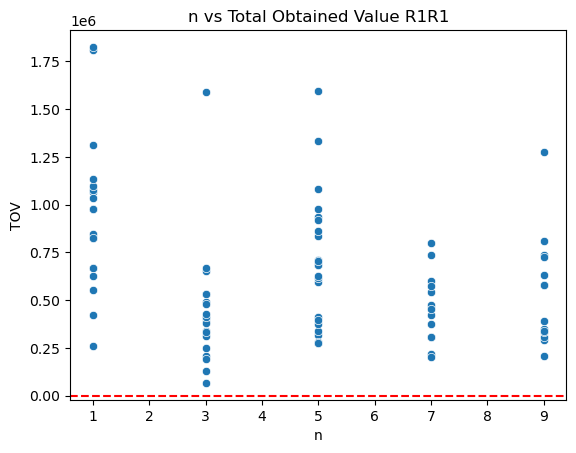

                             TOV Mean         TOV SD
chartist_day_reference                              
1                       947628.886979  405317.248121
3                       439695.168300  313652.425303
5                       689214.930462  341545.569517
7                       462673.859607  177564.910349
9                       540038.986279  285611.624801


                        Open Pos Mean  Open Pos SD
chartist_day_reference                            
1                                20.0          0.0
3                                21.0          0.0
5                                24.0          0.0
7                                18.0          0.0
9                                16.0          0.0


In [8]:
results_chartist_R1R1_df = results_chartist_df[(results_chartist_df.OpenSMA == True)]
results_chartist_R1R1_df = results_chartist_R1R1_df[(results_chartist_R1R1_df.CloseSMA == True)]

g_R1R1 = sns.scatterplot(data=results_chartist_R1R1_df, 
               x="chartist_day_reference", 
               y="TOV")
g_R1R1.set(
    xlabel="n",
    ylabel="TOV",
    title="n vs Total Obtained Value R1R1",
);

plt.axhline(y=0, color='r', linestyle='--', label='y=0')
plt.show()

avg_TVO_per_n_R1R1_df = pd.DataFrame(results_chartist_R1R1_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['TOV'])
avg_TVO_per_n_R1R1_df = avg_TVO_per_n_R1R1_df.rename(columns={'TOV': 'TOV Mean'})
sd_TVO_per_n_R1R1_df = pd.DataFrame(results_chartist_R1R1_df.groupby(['chartist_day_reference']).std(numeric_only=True)['TOV'])
sd_TVO_per_n_R1R1_df = sd_TVO_per_n_R1R1_df.rename(columns={'TOV': 'TOV SD'})

avg_open_pos_per_n_R1R1_df = pd.DataFrame(results_chartist_R1R1_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['Open_R1R1'])
avg_open_pos_per_n_R1R1_df = avg_open_pos_per_n_R1R1_df.rename(columns={'Open_R1R1': 'Open Pos Mean'})
sd_open_pos_per_n_R1R1_df = pd.DataFrame(results_chartist_R1R1_df.groupby(['chartist_day_reference']).std(numeric_only=True)['Open_R1R1'])
sd_open_pos_per_n_R1R1_df = sd_open_pos_per_n_R1R1_df.rename(columns={'Open_R1R1': 'Open Pos SD'})

print(avg_TVO_per_n_R1R1_df.merge(sd_TVO_per_n_R1R1_df, on='chartist_day_reference',how='left'))
print('\n')
print(avg_open_pos_per_n_R1R1_df.merge(sd_open_pos_per_n_R1R1_df, on='chartist_day_reference',how='left'))


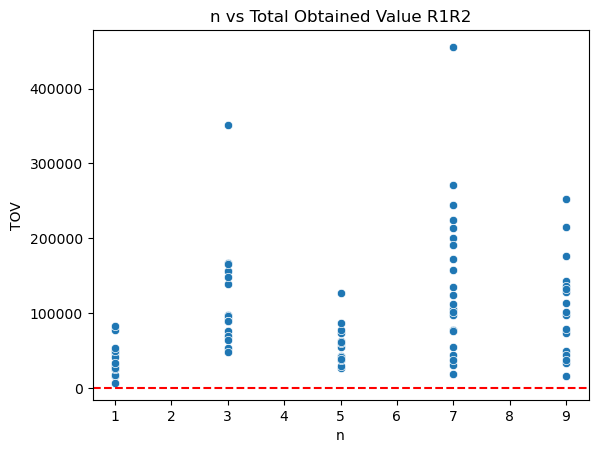

                             TOV Mean        TOV SD
chartist_day_reference                             
1                        37137.315225  20945.430014
3                       121240.885665  71744.821193
5                        58749.788214  26788.607576
7                       140399.189343  99727.115066
9                       107043.642005  60869.047323


                        Open Pos Mean  Open Pos SD
chartist_day_reference                            
1                                 0.0          0.0
3                                 0.0          0.0
5                                 0.0          0.0
7                                 0.0          0.0
9                                 0.0          0.0


In [9]:
results_chartist_R1R2_df = results_chartist_df[(results_chartist_df.OpenSMA == True)]
results_chartist_R1R2_df = results_chartist_R1R2_df[(results_chartist_R1R2_df.CloseSMA == False)]

g_R1R2 = sns.scatterplot(data=results_chartist_R1R2_df, 
               x="chartist_day_reference", 
               y="TOV")
g_R1R2.set(
    xlabel="n",
    ylabel="TOV",
    title="n vs Total Obtained Value R1R2",
);

plt.axhline(y=0, color='r', linestyle='--', label='y=0')
plt.show()

avg_TVO_per_n_R1R2_df = pd.DataFrame(results_chartist_R1R2_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['TOV'])
avg_TVO_per_n_R1R2_df = avg_TVO_per_n_R1R2_df.rename(columns={'TOV': 'TOV Mean'})
sd_TVO_per_n_R1R2_df = pd.DataFrame(results_chartist_R1R2_df.groupby(['chartist_day_reference']).std(numeric_only=True)['TOV'])
sd_TVO_per_n_R1R2_df = sd_TVO_per_n_R1R2_df.rename(columns={'TOV': 'TOV SD'})

avg_open_pos_per_n_R1R2_df = pd.DataFrame(results_chartist_R1R2_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['Open_R1R2'])
avg_open_pos_per_n_R1R2_df = avg_open_pos_per_n_R1R2_df.rename(columns={'Open_R1R2': 'Open Pos Mean'})
sd_open_pos_per_n_R1R2_df = pd.DataFrame(results_chartist_R1R2_df.groupby(['chartist_day_reference']).std(numeric_only=True)['Open_R1R2'])
sd_open_pos_per_n_R1R2_df = sd_open_pos_per_n_R1R2_df.rename(columns={'Open_R1R2': 'Open Pos SD'})

print(avg_TVO_per_n_R1R2_df.merge(sd_TVO_per_n_R1R2_df, on='chartist_day_reference',how='left'))
print('\n')
print(avg_open_pos_per_n_R1R2_df.merge(sd_open_pos_per_n_R1R2_df, on='chartist_day_reference',how='left'))

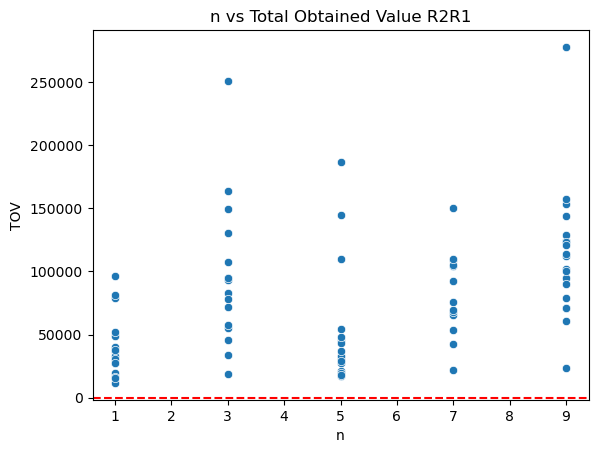

                             TOV Mean        TOV SD
chartist_day_reference                             
1                        40762.101587  25065.276180
3                        95575.963887  57342.690308
5                        52753.016229  48296.208582
7                        82055.921246  34066.993730
9                       113565.444440  50756.251682


                        Open Pos Mean  Open Pos SD
chartist_day_reference                            
1                                 0.0          0.0
3                                 0.0          0.0
5                                 0.0          0.0
7                                 0.0          0.0
9                                 0.0          0.0


In [10]:
results_chartist_R2R1_df = results_chartist_df[(results_chartist_df.OpenSMA == False)]
results_chartist_R2R1_df = results_chartist_R2R1_df[(results_chartist_R2R1_df.CloseSMA == True)]

g_R2R1 = sns.scatterplot(data=results_chartist_R2R1_df, 
               x="chartist_day_reference", 
               y="TOV")
g_R2R1.set(
    xlabel="n",
    ylabel="TOV",
    title="n vs Total Obtained Value R2R1",
);

plt.axhline(y=0, color='r', linestyle='--', label='y=0')
plt.show()

avg_TVO_per_n_R2R1_df = pd.DataFrame(results_chartist_R2R1_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['TOV'])
avg_TVO_per_n_R2R1_df = avg_TVO_per_n_R2R1_df.rename(columns={'TOV': 'TOV Mean'})
sd_TVO_per_n_R2R1_df = pd.DataFrame(results_chartist_R2R1_df.groupby(['chartist_day_reference']).std(numeric_only=True)['TOV'])
sd_TVO_per_n_R2R1_df = sd_TVO_per_n_R2R1_df.rename(columns={'TOV': 'TOV SD'})

avg_open_pos_per_n_R2R1_df = pd.DataFrame(results_chartist_R2R1_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['Open_R2R1'])
avg_open_pos_per_n_R2R1_df = avg_open_pos_per_n_R2R1_df.rename(columns={'Open_R2R1': 'Open Pos Mean'})
sd_open_pos_per_n_R2R1_df = pd.DataFrame(results_chartist_R2R1_df.groupby(['chartist_day_reference']).std(numeric_only=True)['Open_R2R1'])
sd_open_pos_per_n_R2R1_df = sd_open_pos_per_n_R2R1_df.rename(columns={'Open_R2R1': 'Open Pos SD'})

print(avg_TVO_per_n_R2R1_df.merge(sd_TVO_per_n_R2R1_df, on='chartist_day_reference',how='left'))
print('\n')
print(avg_open_pos_per_n_R2R1_df.merge(sd_open_pos_per_n_R2R1_df, on='chartist_day_reference',how='left'))

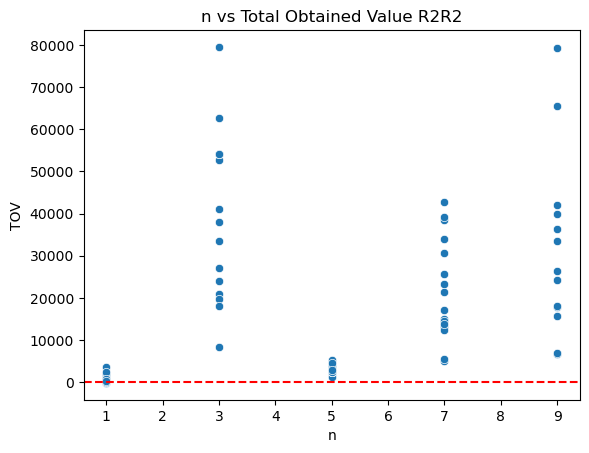

                            TOV Mean        TOV SD
chartist_day_reference                            
1                         925.569919    999.101553
3                       38101.884000  20238.718436
5                        2803.312608   1235.646279
7                       21465.141265  11786.923278
9                       31683.397215  21523.759530


                        Open Pos Mean  Open Pos SD
chartist_day_reference                            
1                                14.0          0.0
3                                11.0          0.0
5                                12.0          0.0
7                                11.0          0.0
9                                19.0          0.0


In [11]:
results_chartist_R2R2_df = results_chartist_df[(results_chartist_df.OpenSMA == False)]
results_chartist_R2R2_df = results_chartist_R2R2_df[(results_chartist_R2R2_df.CloseSMA == False)]

g_R2R2 = sns.scatterplot(data=results_chartist_R2R2_df, 
               x="chartist_day_reference", 
               y="TOV")
g_R2R2.set(
    xlabel="n",
    ylabel="TOV",
    title="n vs Total Obtained Value R2R2",
);

plt.axhline(y=0, color='r', linestyle='--', label='y=0')
plt.show()

avg_TVO_per_n_R2R2_df = pd.DataFrame(results_chartist_R2R2_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['TOV'])
avg_TVO_per_n_R2R2_df = avg_TVO_per_n_R2R2_df.rename(columns={'TOV': 'TOV Mean'})
sd_TVO_per_n_R2R2_df = pd.DataFrame(results_chartist_R2R2_df.groupby(['chartist_day_reference']).std(numeric_only=True)['TOV'])
sd_TVO_per_n_R2R2_df = sd_TVO_per_n_R2R2_df.rename(columns={'TOV': 'TOV SD'})

avg_open_pos_per_n_R2R2_df = pd.DataFrame(results_chartist_R2R2_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['Open_R2R2'])
avg_open_pos_per_n_R2R2_df = avg_open_pos_per_n_R2R2_df.rename(columns={'Open_R2R2': 'Open Pos Mean'})
sd_open_pos_per_n_R2R2_df = pd.DataFrame(results_chartist_R2R2_df.groupby(['chartist_day_reference']).std(numeric_only=True)['Open_R2R2'])
sd_open_pos_per_n_R2R2_df = sd_open_pos_per_n_R2R2_df.rename(columns={'Open_R2R2': 'Open Pos SD'})

print(avg_TVO_per_n_R2R2_df.merge(sd_TVO_per_n_R2R2_df, on='chartist_day_reference',how='left'))
print('\n')
print(avg_open_pos_per_n_R2R2_df.merge(sd_open_pos_per_n_R2R2_df, on='chartist_day_reference',how='left'))

## Task 2.2 Agent Comparisons

In [25]:
best_n_R1R1 = 1
best_n_R1R2 = 7
best_n_R2R1 = 9
best_n_R2R2 = 3

results_chartist_R1R1__best_n_df = results_chartist_R1R1_df[(results_chartist_R1R1_df.chartist_day_reference == best_n_R1R1)]
results_chartist_R1R2__best_n_df = results_chartist_R1R2_df[(results_chartist_R1R2_df.chartist_day_reference == best_n_R1R2)]
results_chartist_R2R1__best_n_df = results_chartist_R2R1_df[(results_chartist_R2R1_df.chartist_day_reference == best_n_R2R1)]
results_chartist_R2R2__best_n_df = results_chartist_R2R2_df[(results_chartist_R2R2_df.chartist_day_reference == best_n_R2R2)]

results_random_df = results_df[(results_df["AgentID"].str.contains("random"))]
results_random_df = results_random_df[(results_random_df.Step == max_steps)]
results_random_best_n_df = results_random_df[(results_random_df.chartist_day_reference == best_n_R1R1)]

# print(results_chartist_R1R1__best_n_df.head(3))

In [26]:
print('TOV')
summary_TOV = pd.DataFrame({
    'Agent Name': ['R1R1','R1R2','R2R1', 'R2R2', 'Random'],
    'Avg': [results_chartist_R1R1__best_n_df.mean(numeric_only=True)['TOV'],
           results_chartist_R1R2__best_n_df.mean(numeric_only=True)['TOV'],
           results_chartist_R2R1__best_n_df.mean(numeric_only=True)['TOV'],
           results_chartist_R2R2__best_n_df.mean(numeric_only=True)['TOV'],
           results_random_best_n_df.mean(numeric_only=True)['TOV']],
    'SD': [results_chartist_R1R1__best_n_df.std(numeric_only=True)['TOV'],
           results_chartist_R1R2__best_n_df.std(numeric_only=True)['TOV'],
           results_chartist_R2R1__best_n_df.std(numeric_only=True)['TOV'],
           results_chartist_R2R2__best_n_df.std(numeric_only=True)['TOV'], 
           results_random_best_n_df.std(numeric_only=True)['TOV']]
})
print(summary_TOV)

fig = px.histogram(summary_TOV, x="Agent Name" , y=["Avg", "SD"], opacity=0.7, barmode='overlay',
                   facet_col='variable',
                   title='Histogram for Avg and SD',
                   labels={'value': 'Value', 'variable': 'Columns'})

fig.show()

TOV
  Agent Name            Avg             SD
0       R1R1  947628.886979  405317.248121
1       R1R2  140399.189343   99727.115066
2       R2R1  113565.444440   50756.251682
3       R2R2   38101.884000   20238.718436
4     Random   56030.331296   37215.843663


In [27]:
print('Open Position')
summary_open_pos = pd.DataFrame({
    'Agent Name': ['R1R1','R1R2','R2R1', 'R2R2', 'Random'],
    'Avg': [results_chartist_R1R1__best_n_df.mean(numeric_only=True)['Open_R1R1'],
           results_chartist_R1R2__best_n_df.mean(numeric_only=True)['Open_R1R2'],
           results_chartist_R2R1__best_n_df.mean(numeric_only=True)['Open_R2R1'],
           results_chartist_R2R2__best_n_df.mean(numeric_only=True)['Open_R2R2'],
           results_random_best_n_df.mean(numeric_only=True)['Open_Random']],
    'SD': [results_chartist_R1R1__best_n_df.std(numeric_only=True)['Open_R1R1'],
           results_chartist_R1R2__best_n_df.std(numeric_only=True)['Open_R1R2'],
           results_chartist_R2R1__best_n_df.std(numeric_only=True)['Open_R2R1'],
           results_chartist_R2R2__best_n_df.std(numeric_only=True)['Open_R2R2'], 
           results_random_best_n_df.std(numeric_only=True)['Open_Random']]
})
print(summary_open_pos)

fig = px.histogram(summary_open_pos, x="Agent Name" , y=["Avg", "SD"], opacity=0.7, barmode='overlay',
                   facet_col='variable',
                   title='Histogram for Avg and SD',
                   labels={'value': 'Value', 'variable': 'Columns'})

fig.show()

Open Position
  Agent Name   Avg   SD
0       R1R1  20.0  0.0
1       R1R2   0.0  0.0
2       R2R1   0.0  0.0
3       R2R2  11.0  0.0
4     Random  24.0  0.0


In [28]:
print('Ratio Bitcoin vs Fiat')
summary_ratio = pd.DataFrame({
    'Agent Name': ['R1R1','R1R2','R2R1', 'R2R2', 'Random'],
    'Avg': [results_chartist_R1R1__best_n_df.mean(numeric_only=True)['RBF'],
           results_chartist_R1R2__best_n_df.mean(numeric_only=True)['RBF'],
           results_chartist_R2R1__best_n_df.mean(numeric_only=True)['RBF'],
           results_chartist_R2R2__best_n_df.mean(numeric_only=True)['RBF'],
           results_random_best_n_df.mean(numeric_only=True)['RBF']],
    'SD': [results_chartist_R1R1__best_n_df.std(numeric_only=True)['RBF'],
           results_chartist_R1R2__best_n_df.std(numeric_only=True)['RBF'],
           results_chartist_R2R1__best_n_df.std(numeric_only=True)['RBF'],
           results_chartist_R2R2__best_n_df.std(numeric_only=True)['RBF'], 
           results_random_best_n_df.std(numeric_only=True)['RBF']]
})
print(summary_ratio)

fig = px.histogram(summary_ratio, x="Agent Name" , y=["Avg", "SD"], opacity=0.7, barmode='overlay',
                   facet_col='variable',
                   title='Histogram for Avg and SD',
                   labels={'value': 'Value', 'variable': 'Columns'})

fig.show()

Ratio Bitcoin vs Fiat
  Agent Name          Avg           SD
0       R1R1  2627.460000  7749.451794
1       R1R2    91.575652   180.312958
2       R2R1   661.267500  1838.769042
3       R2R2     5.610714    20.993371
4     Random    30.666444    49.398253


# Task 3 Model Validation

In [29]:
# # results_price_df = results_df[(results_df.iteration == 0)]
# results_price_df = results_df.copy()
# results_price_df = results_price_df.loc[:,["iteration", "Step", "Price"]]
# results_price_df = results_price_df.groupby(['iteration', 'Step']).max()['Price']
# results_price_df = results_price_df.groupby(["Step"]).mean()
# print(results_price_df.groupby(["Step"]).mean())

# fig = px.line(results_price_df, y = 'Price', title = 'Price', markers = True)

# fig.show()

In [30]:
# total_bitcoin = 10000
# total_fiat = 5000000

# # Agents Parameters
# number_of_agents = 5 # In 2020, there are 420M users
# chartist_day_reference = 3
# chartist_ratio = 0.5

# price_start = 5614

# model = BitcoinMarketModel(price_start, 
#                            number_of_agents, 
#                            total_fiat, 
#                            total_bitcoin, 
#                            chartist_ratio, 
#                            chartist_day_reference)

# for i in range(10):
# #     print(f'progress : {i}/1399')
#     model.step()
    
# data = model.datacollector.get_model_vars_dataframe()

# price_df = pd.DataFrame(data=data.Price)
# fig = px.line(price_df, y = 'Price', title = 'Price', markers = True)

# fig.show()

# agent_variables = model.datacollector.get_agent_vars_dataframe()
# end_state = agent_variables.index.get_level_values("Step").max()
# end_state_total_value = agent_variables.xs(end_state, level="Step")["TV"]
# agents_total_value_df = pd.DataFrame(data=end_state_total_value)

# # # Create a histogram of wealth at the last step
# counts, bins = np.histogram(agents_total_value_df, bins=range(0, 5000000, 1000000))
# bins = 0.5 * (bins[:-1] + bins[1:])

# fig = px.bar(x=bins, y=counts, labels={'x':'total_values', 'y':'count'})
# fig.show()